Generalization and Neural Networks
==================================

### [Neil D. Lawrence](http://inverseprobability.com)

### 2021-01-26

**Abstract**: This lecture will cover generalization in machine learning
with a particular focus on neural architectures. We will review
classical generalization and explore what’s different about neural
network models.

$$
$$

<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!---->
<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!-- The last names to be defined. Should be defined entirely in terms of macros from above-->
<!--

-->

Setup
-----

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_deepnn/includes/deepnn-notebook-setup.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_deepnn/includes/deepnn-notebook-setup.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

First we download some libraries and files to support the notebook.

In [ ]:
import urllib.request

In [ ]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/mlai.py','mlai.py')

In [ ]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/teaching_plots.py','teaching_plots.py')

In [ ]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/gp_tutorial.py','gp_tutorial.py')

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

<!--setupplotcode{import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set_palette('colorblind')}-->

pods
----

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_data-science/includes/pods-software.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_data-science/includes/pods-software.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

In Sheffield we created a suite of software tools for ‘Open Data
Science’. Open data science is an approach to sharing code, models and
data that should make it easier for companies, health professionals and
scientists to gain access to data science techniques.

You can also check this blog post on [Open Data
Science](http://inverseprobability.com/2014/07/01/open-data-science).

The software can be installed using

In [ ]:
%pip install --upgrade git+https://github.com/sods/ods

from the command prompt where you can access your python installation.

The code is also available on github:
<a href="https://github.com/sods/ods" class="uri">https://github.com/sods/ods</a>

Once `pods` is installed, it can be imported in the usual manner.

In [ ]:
import pods

Quadratic Loss and Linear System
--------------------------------

We will consider a simplified system, to remind us of some of the linear
algebra involved, and introduce some of the fundamental issues.

Expected Loss
-------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/expected-loss.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/expected-loss.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

Our objective function so far has been the negative log likelihood,
which we have minimized (via the sum of squares error) to obtain our
model. However, there is an alternative perspective on an objective
function, that of a *loss function*. A loss function is a cost function
associated with the penalty you might need to pay for a particular
incorrect decision. One approach to machine learning involves specifying
a loss function and considering how much a particular model is likely to
cost us across its lifetime. We can represent this with an expectation.
If our loss function is given as $L(y, x, \mathbf{ w})$ for a particular
model that predicts $y$ given $x$ and $\mathbf{ w}$ then we are
interested in minimizing the expected loss under the likely distribution
of $y$ and $x$. To understand this formally we define the *true*
distribution of the data samples, $y$, $x$. This is a particular
distribution that we don’t typically have access to. To represent it we
define a variant of the letter ‘P’, $\mathbb{P}(y, x)$. If we genuinely
pay $L(y, x, \mathbf{ w})$ for every mistake we make, and the future
test data is genuinely drawn from $\mathbb{P}(y, x)$ then we can define
our expected loss, or risk, to be, $$
R(\mathbf{ w}) = \int L(y, x, \mathbf{ w}) \mathbb{P}(y, x) \text{d}y
\text{d}x.
$$ Of course, in practice, this value can’t be computed *but* it serves
as a reminder of what it is we are aiming to minimize and under certain
circumstances it can be approximated.

Sample Based Approximations
---------------------------

A sample based approximation to an expectation involves replacing the
true expectation with a sum over samples from the distribution. $$
\int f(z) p(z) \text{d}z\approx \frac{1}{s}\sum_{i=1}^s f(z_i).
$$ if $\{z_i\}_{i=1}^s$ are a set of $s$ independent and identically
distributed samples from the distribution $p(z)$. This approximation
becomes better for larger $s$, although the *rate of convergence* to the
true integral will be very dependent on the distribution $p(z)$ *and*
the function $f(z)$.

That said, this means we can approximate our true integral with the sum,
$$
R(\mathbf{ w}) \approx \frac{1}{n}\sum_{i=1}^{n} L(y_i, x_i, \mathbf{ w}).
$$

Quadratic Loss
--------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/linear-regression-direct-solution.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/linear-regression-direct-solution.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

$$
R(\mathbf{ w}) = \sum_{i=1}^n\left(y_i - f(\mathbf{ x}_i, \mathbf{ w})\right)^2
$$

$$
R(\mathbf{ w}) = \sum_{i=1}^n\left(y_i - \mathbf{ w}^\top \mathbf{ x}_i\right)^2
$$

Bracket Expansion
-----------------

$$
\begin{align*}
  L(\mathbf{ w},\sigma^2)  = &
\frac{n}{2}\log \sigma^2 + \frac{1}{2\sigma^2}\sum
_{i=1}^{n}y_i^{2}-\frac{1}{\sigma^2}\sum
_{i=1}^{n}y_i\mathbf{ w}^{\top}\mathbf{ x}_i\\&+\frac{1}{2\sigma^2}\sum
_{i=1}^{n}\mathbf{ w}^{\top}\mathbf{ x}_i\mathbf{ x}_i^{\top}\mathbf{ w}
+\text{const}.\\
    = & \frac{n}{2}\log \sigma^2 + \frac{1}{2\sigma^2}\sum
_{i=1}^{n}y_i^{2}-\frac{1}{\sigma^2}
\mathbf{ w}^\top\sum_{i=1}^{n}\mathbf{ x}_iy_i\\&+\frac{1}{2\sigma^2}
\mathbf{ w}^{\top}\left[\sum
_{i=1}^{n}\mathbf{ x}_i\mathbf{ x}_i^{\top}\right]\mathbf{ w}+\text{const}.
\end{align*}
$$

Multiple Input Solution with Linear Algebra
===========================================

You’ve now seen how slow it can be to perform a coordinate ascent on a
system. Another approach to solving the system (which is not always
possible, particularly in *non-linear* systems) is to go direct to the
minimum. To do this we need to introduce *linear algebra*. We will
represent all our errors and functions in the form of linear algebra. As
we mentioned above, linear algebra is just a shorthand for performing
lots of multiplications and additions simultaneously. What does it have
to do with our system then? Well the first thing to note is that the
linear function we were trying to fit has the following form: $$
f(x) = mx + c
$$ the classical form for a straight line. From a linear algebraic
perspective we are looking for multiplications and additions. We are
also looking to separate our parameters from our data. The data is the
*givens* remember, in French the word is données literally translated
means *givens* that’s great, because we don’t need to change the data,
what we need to change are the parameters (or variables) of the model.
In this function the data comes in through $x$, and the parameters are
$m$ and $c$.

What we’d like to create is a vector of parameters and a vector of data.
Then we could represent the system with vectors that represent the data,
and vectors that represent the parameters.

We look to turn the multiplications and additions into a linear
algebraic form, we have one multiplication ($m\times c$) and one
addition ($mx + c$). But we can turn this into a inner product by
writing it in the following way, $$
f(x) = m \times x +
c \times 1,
$$ in other words we’ve extracted the unit value, from the offset, $c$.
We can think of this unit value like an extra item of data, because it
is always given to us, and it is always set to 1 (unlike regular data,
which is likely to vary!). We can therefore write each input data
location, $\mathbf{ x}$, as a vector $$
\boldsymbol{ \phi}= \begin{bmatrix} 1\\ x\end{bmatrix}.
$$

Now we choose to also turn our parameters into a vector. The parameter
vector will be defined to contain $$
\mathbf{ w}= \begin{bmatrix} c \\ m\end{bmatrix}
$$ because if we now take the inner product between these to vectors we
recover $$
\boldsymbol{ \phi}\cdot\mathbf{ w}= 1 \times c + x \times m = mx + c
$$ In `numpy` we can define this vector as follows

In [ ]:
import numpy as np

In [ ]:
# define the vector w
w = np.zeros(shape=(2, 1))
w[0] = m
w[1] = c

This gives us the equivalence between original operation and an
operation in vector space. Whilst the notation here isn’t a lot shorter,
the beauty is that we will be able to add as many features as we like
and still keep the seame representation. In general, we are now moving
to a system where each of our predictions is given by an inner product.
When we want to represent a linear product in linear algebra, we tend to
do it with the transpose operation, so since we have
$\mathbf{a}\cdot\mathbf{b} = \mathbf{a}^\top\mathbf{b}$ we can write $$
f(\mathbf{ x}_i) = \designVector_i^\top\mathbf{ w}.
$$ Where we’ve assumed that each data point, $\designVector_i$, is now
written by appending a 1 onto the original vector $$
\designVector_i = \begin{bmatrix} 
1 \\
x_i
\end{bmatrix}
$$

Design Matrix
=============

We can do this for the entire data set to form a [*design
matrix*](http://en.wikipedia.org/wiki/Design_matrix)
$\boldsymbol{ \Phi}$,

$$\boldsymbol{ \Phi}
= \begin{bmatrix} 
\designVector_1^\top \\\ 
\designVector_2^\top \\\ 
\vdots \\\
\designVector_n^\top
\end{bmatrix} = \begin{bmatrix}
1 & x_1 \\\
1 & x_2 \\\
\vdots
& \vdots \\\
1 & x_n
\end{bmatrix},$$

which in `numpy` can be done with the following commands:

In [ ]:
import numpy as np

In [ ]:
Phi = np.hstack((np.ones_like(x), x))
print(Phi)

Writing the Objective with Linear Algebra
-----------------------------------------

When we think of the objective function, we can think of it as the
errors where the error is defined in a similar way to what it was in
Legendre’s day $y_i - f(\mathbf{ x}_i)$, in statistics these errors are
also sometimes called
[*residuals*](http://en.wikipedia.org/wiki/Errors_and_residuals_in_statistics).
So we can think as the objective and the prediction function as two
separate parts, first we have, $$
L(\mathbf{ w}) = \sum_{i=1}^n(y_i - f(\mathbf{ x}_i; \mathbf{ w}))^2,
$$ where we’ve made the function $f(\cdot)$’s dependence on the
parameters $\mathbf{ w}$ explicit in this equation. Then we have the
definition of the function itself, $$
f(\mathbf{ x}_i; \mathbf{ w}) = \designVector_i^\top \mathbf{ w}.
$$ Let’s look again at these two equations and see if we can identify
any inner products. The first equation is a sum of squares, which is
promising. Any sum of squares can be represented by an inner product, $$
a = \sum_{i=1}^{k} b^2_i = \mathbf{b}^\top\mathbf{b},
$$ so if we wish to represent $L(\mathbf{ w})$ in this way, all we need
to do is convert the sum operator to an inner product. We can get a
vector from that sum operator by placing both $y_i$ and
$f(\mathbf{ x}_i; \mathbf{ w})$ into vectors, which we do by defining $$
\mathbf{ y}= \begin{bmatrix}y_1\\ y_2\\ \vdots \\ y_n\end{bmatrix}
$$ and defining $$
\mathbf{ f}(\mathbf{ x}_1; \mathbf{ w}) = \begin{bmatrix}f(\mathbf{ x}_1; \mathbf{ w})\\ f(\mathbf{ x}_2; \mathbf{ w})\\ \vdots \\ f(\mathbf{ x}_n; \mathbf{ w})\end{bmatrix}.
$$ The second of these is actually a vector-valued function. This term
may appear intimidating, but the idea is straightforward. A vector
valued function is simply a vector whose elements are themselves defined
as *functions*, i.e. it is a vector of functions, rather than a vector
of scalars. The idea is so straightforward, that we are going to ignore
it for the moment, and barely use it in the derivation. But it will
reappear later when we introduce *basis functions*. So we will, for the
moment, ignore the dependence of $\mathbf{ f}$ on $\mathbf{ w}$ and
$\boldsymbol{ \Phi}$ and simply summarise it by a vector of numbers $$
\mathbf{ f}= \begin{bmatrix}f_1\\f_2\\
\vdots \\ f_n\end{bmatrix}.
$$ This allows us to write our objective in the folowing, linear
algebraic form, $$
L(\mathbf{ w}) = (\mathbf{ y}- \mathbf{ f})^\top(\mathbf{ y}- \mathbf{ f})
$$ from the rules of inner products. But what of our matrix
$\boldsymbol{ \Phi}$ of input data? At this point, we need to dust off
[*matrix-vector
multiplication*](http://en.wikipedia.org/wiki/Matrix_multiplication).
Matrix multiplication is simply a convenient way of performing many
inner products together, and it’s exactly what we need to summarise the
operation $$
f_i = \designVector_i^\top\mathbf{ w}.
$$ This operation tells us that each element of the vector $\mathbf{ f}$
(our vector valued function) is given by an inner product between
$\mathbf{ x}_i$ and $\mathbf{ w}$. In other words it is a series of
inner products. Let’s look at the definition of matrix multiplication,
it takes the form $$
\mathbf{c} = \mathbf{B}\mathbf{a},
$$ where $\mathbf{c}$ might be a $k$ dimensional vector (which we can
intepret as a $k\times 1$ dimensional matrix), and $\mathbf{B}$ is a
$k\times k$ dimensional matrix and $\mathbf{a}$ is a $k$ dimensional
vector ($k\times 1$ dimensional matrix).

The result of this multiplication is of the form $$
\begin{bmatrix}c_1\\c_2 \\ \vdots \\
a_k\end{bmatrix} = 
\begin{bmatrix} b_{1,1} & b_{1, 2} & \dots & b_{1, k} \\
b_{2, 1} & b_{2, 2} & \dots & b_{2, k} \\
\vdots & \vdots & \ddots & \vdots \\
b_{k, 1} & b_{k, 2} & \dots & b_{k, k} \end{bmatrix} \begin{bmatrix}a_1\\a_2 \\
\vdots\\ c_k\end{bmatrix} = \begin{bmatrix} b_{1, 1}a_1 + b_{1, 2}a_2 + \dots +
b_{1, k}a_k\\
b_{2, 1}a_1 + b_{2, 2}a_2 + \dots + b_{2, k}a_k \\ 
\vdots\\
b_{k, 1}a_1 + b_{k, 2}a_2 + \dots + b_{k, k}a_k\end{bmatrix}
$$ so we see that each element of the result, $\mathbf{a}$ is simply the
inner product between each *row* of $\mathbf{B}$ and the vector
$\mathbf{c}$. Because we have defined each element of $\mathbf{ f}$ to
be given by the inner product between each *row* of the design matrix
and the vector $\mathbf{ w}$ we now can write the full operation in one
matrix multiplication,

$$
\mathbf{ f}= \boldsymbol{ \Phi}\mathbf{ w}.
$$

In [ ]:
import numpy as np

In [ ]:
f = Phi@w # The @ sign performs matrix multiplication

Combining this result with our objective function, $$
L(\mathbf{ w}) = (\mathbf{ y}- \mathbf{ f})^\top(\mathbf{ y}- \mathbf{ f})
$$ we find we have defined the *model* with two equations. One equation
tells us the form of our predictive function and how it depends on its
parameters, the other tells us the form of our objective function.

In [ ]:
resid = (y-f)
E = np.dot(resid.T, resid) # matrix multiplication on a single vector is equivalent to a dot product.
print("Error function is:", E)

Objective Optimisation
======================

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/linear-regression-objective-optimisation.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/linear-regression-objective-optimisation.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

Our *model* has now been defined with two equations, the prediction
function and the objective function. Next we will use multivariate
calculus to define an *algorithm* to fit the model. The separation
between model and algorithm is important and is often overlooked. Our
model contains a function that shows how it will be used for prediction,
and a function that describes the objective function we need to optimise
to obtain a good set of parameters.

The model linear regression model we have described is still the same as
the one we fitted above with a coordinate ascent algorithm. We have only
played with the notation to obtain the same model in a matrix and vector
notation. However, we will now fit this model with a different
algorithm, one that is much faster. It is such a widely used algorithm
that from the end user’s perspective it doesn’t even look like an
algorithm, it just appears to be a single operation (or function).
However, underneath the computer calls an algorithm to find the
solution. Further, the algorithm we obtain is very widely used, and
because of this it turns out to be highly optimised.

Once again we are going to try and find the stationary points of our
objective by finding the *stationary points*. However, the stationary
points of a multivariate function, are a little bit more complext to
find. Once again we need to find the point at which the derivative is
zero, but now we need to use *multivariate calculus* to find it. This
involves learning a few additional rules of differentiation (that allow
you to do the derivatives of a function with respect to vector), but in
the end it makes things quite a bit easier. We define vectorial
derivatives as follows, $$
\frac{\text{d}L(\mathbf{ w})}{\text{d}\mathbf{ w}} =
\begin{bmatrix}\frac{\text{d}L(\mathbf{ w})}{\text{d}w_1}\\\frac{\text{d}L(\mathbf{ w})}{\text{d}w_2}\end{bmatrix}.
$$ where $\frac{\text{d}L(\mathbf{ w})}{\text{d}w_1}$ is the [partial
derivative](http://en.wikipedia.org/wiki/Partial_derivative) of the
error function with respect to $w_1$.

Differentiation through multiplications and additions is relatively
straightforward, and since linear algebra is just multiplication and
addition, then its rules of diffentiation are quite straightforward too,
but slightly more complex than regular derivatives.

Multivariate Derivatives
------------------------

We will need two rules of multivariate or *matrix* differentiation. The
first is diffentiation of an inner product. By remembering that the
inner product is made up of multiplication and addition, we can hope
that its derivative is quite straightforward, and so it proves to be. We
can start by thinking about the definition of the inner product, $$
\mathbf{a}^\top\mathbf{z} = \sum_{i} a_i
z_i,
$$ which if we were to take the derivative with respect to $z_k$ would
simply return the gradient of the one term in the sum for which the
derivative was non zero, that of $a_k$, so we know that $$
\frac{\text{d}}{\text{d}z_k} \mathbf{a}^\top \mathbf{z} = a_k
$$ and by our definition of multivariate derivatives we can simply stack
all the partial derivatives of this form in a vector to obtain the
result that $$
\frac{\text{d}}{\text{d}\mathbf{z}}
\mathbf{a}^\top \mathbf{z} = \mathbf{a}.
$$ The second rule that’s required is differentiation of a ‘matrix
quadratic’. A scalar quadratic in $z$ with coefficient $c$ has the form
$cz^2$. If $\mathbf{z}$ is a $k\times 1$ vector and $\mathbf{C}$ is a
$k \times k$ *matrix* of coefficients then the matrix quadratic form is
written as $\mathbf{z}^\top \mathbf{C}\mathbf{z}$, which is itself a
*scalar* quantity, but it is a function of a *vector*.

### Matching Dimensions in Matrix Multiplications

There’s a trick for telling that it’s a scalar result. When you are
doing maths with matrices, it’s always worth pausing to perform a quick
sanity check on the dimensions. Matrix multplication only works when the
dimensions match. To be precise, the ‘inner’ dimension of the matrix
must match. What is the inner dimension. If we multiply two matrices
$\mathbf{A}$ and $\mathbf{B}$, the first of which has $k$ rows and
$\ell$ columns and the second of which has $p$ rows and $q$ columns,
then we can check whether the multiplication works by writing the
dimensionalities next to each other, $$
\mathbf{A} \mathbf{B} \rightarrow (k \times
\underbrace{\ell)(p}_\text{inner dimensions} \times q) \rightarrow (k\times q).
$$ The inner dimensions are the two inside dimensions, $\ell$ and $p$.
The multiplication will only work if $\ell=p$. The result of the
multiplication will then be a $k\times q$ matrix: this dimensionality
comes from the ‘outer dimensions’. Note that matrix multiplication is
not [*commutative*](http://en.wikipedia.org/wiki/Commutative_property).
And if you change the order of the multiplication, $$
\mathbf{B} \mathbf{A} \rightarrow (\ell \times \underbrace{k)(q}_\text{inner dimensions} \times p) \rightarrow (\ell \times p).
$$ firstly it may no longer even work, because now the condition is that
$k=q$, and secondly the result could be of a different dimensionality.
An exception is if the matrices are square matrices (e.g. same number of
rows as columns) and they are both *symmetric*. A symmetric matrix is
one for which $\mathbf{A}=\mathbf{A}^\top$, or equivalently,
$a_{i,j} = a_{j,i}$ for all $i$ and $j$.

You will need to get used to working with matrices and vectors applying
and developing new machine learning techniques. You should have come
across them before, but you may not have used them as extensively as we
will now do in this course. You should get used to using this trick to
check your work and ensure you know what the dimension of an output
matrix should be. For our matrix quadratic form, it turns out that we
can see it as a special type of inner product. $$
\mathbf{z}^\top\mathbf{C}\mathbf{z} \rightarrow (1\times
\underbrace{k) (k}_\text{inner dimensions}\times k) (k\times 1) \rightarrow
\mathbf{b}^\top\mathbf{z}
$$ where $\mathbf{b} = \mathbf{C}\mathbf{z}$ so therefore the result is
a scalar, $$
\mathbf{b}^\top\mathbf{z} \rightarrow
(1\times \underbrace{k) (k}_\text{inner dimensions}\times 1) \rightarrow
(1\times 1)
$$ where a $(1\times 1)$ matrix is recognised as a scalar.

This implies that we should be able to differentiate this form, and
indeed the rule for its differentiation is slightly more complex than
the inner product, but still quite simple, $$
\frac{\text{d}}{\text{d}\mathbf{z}}
\mathbf{z}^\top\mathbf{C}\mathbf{z}= \mathbf{C}\mathbf{z} + \mathbf{C}^\top
\mathbf{z}.
$$ Note that in the special case where $\mathbf{C}$ is symmetric then we
have $\mathbf{C} = \mathbf{C}^\top$ and the derivative simplifies to $$
\frac{\text{d}}{\text{d}\mathbf{z}} \mathbf{z}^\top\mathbf{C}\mathbf{z}=
2\mathbf{C}\mathbf{z}.
$$

::: {.cell .markdown}

Differentiate the Objective
---------------------------

First, we need to compute the full objective by substituting our
prediction function into the objective function to obtain the objective
in terms of $\mathbf{ w}$. Doing this we obtain $$
L(\mathbf{ w})= (\mathbf{ y}- \boldsymbol{ \Phi}\mathbf{ w})^\top (\mathbf{ y}- \boldsymbol{ \Phi}\mathbf{ w}).
$$ We now need to differentiate this *quadratic form* to find the
minimum. We differentiate with respect to the *vector* $\mathbf{ w}$.
But before we do that, we’ll expand the brackets in the quadratic form
to obtain a series of scalar terms. The rules for bracket expansion
across the vectors are similar to those for the scalar system giving, $$
(\mathbf{a} - \mathbf{b})^\top
(\mathbf{c} - \mathbf{d}) = \mathbf{a}^\top \mathbf{c} - \mathbf{a}^\top
\mathbf{d} - \mathbf{b}^\top \mathbf{c} + \mathbf{b}^\top \mathbf{d}
$$ which substituting for $\mathbf{a} = \mathbf{c} = \mathbf{ y}$ and
$\mathbf{b}=\mathbf{d} = \boldsymbol{ \Phi}\mathbf{ w}$ gives $$
L(\mathbf{ w})=
\mathbf{ y}^\top\mathbf{ y}- 2\mathbf{ y}^\top\boldsymbol{ \Phi}\mathbf{ w}+
\mathbf{ w}^\top\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ w}
$$ where we used the fact that
$\mathbf{ y}^\top\boldsymbol{ \Phi}\mathbf{ w}=\mathbf{ w}^\top\boldsymbol{ \Phi}^\top\mathbf{ y}$.

Now we can use our rules of differentiation to compute the derivative of
this form, which is, $$
\frac{\text{d}}{\text{d}\mathbf{ w}}L(\mathbf{ w})=- 2\boldsymbol{ \Phi}^\top \mathbf{ y}+
2\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ w},
$$ where we have exploited the fact that
$\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}$ is symmetric to obtain this
result.

### Exercise 1

Use the equivalence between our vector and our matrix formulations of
linear regression, alongside our definition of vector derivates, to
match the gradients we’ve computed directly for
$\frac{\text{d}L(c, m)}{\text{d}c}$ and
$\frac{\text{d}L(c, m)}{\text{d}m}$ to those for
$\frac{\text{d}L(\mathbf{ w})}{\text{d}\mathbf{ w}}$.

### Exercise 1 Answer

Write your answer to Exercise 1 here

Update Equation for Global Optimum
==================================

Once again, we need to find the minimum of our objective function. Using
our likelihood for multiple input regression we can now minimize for our
parameter vector $\mathbf{ w}$. Firstly, just as in the single input
case, we seek stationary points by find parameter vectors that solve for
when the gradients are zero, $$
\mathbf{0}=- 2\boldsymbol{ \Phi}^\top
\mathbf{ y}+ 2\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ w},
$$ where $\mathbf{0}$ is a *vector* of zeros. Rearranging this equation
we find the solution to be $$
\mathbf{ w}= \left[\boldsymbol{ \Phi}^\top \boldsymbol{ \Phi}\right]^{-1} \boldsymbol{ \Phi}^\top
\mathbf{ y}
$$ where $\mathbf{A}^{-1}$ denotes [*matrix
inverse*](http://en.wikipedia.org/wiki/Invertible_matrix).

Solving the Multivariate System
-------------------------------

The solution for $\mathbf{ w}$ is given in terms of a matrix inverse,
but computation of a matrix inverse requires, in itself, an algorithm to
resolve it. You’ll know this if you had to invert, by hand, a
$3\times 3$ matrix in high school. From a numerical stability
perspective, it is also best not to compute the matrix inverse directly,
but rather to ask the computer to *solve* the system of linear equations
given by $$
\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ w}= \boldsymbol{ \Phi}^\top\mathbf{ y}
$$ for $\mathbf{ w}$.

Multivariate Linear Regression
------------------------------

A major advantage of the new system is that we can build a linear
regression on a multivariate system. The matrix calculus didn’t specify
what the length of the vector $\mathbf{ x}$ should be, or equivalently
the size of the design matrix.

Hessian Matrix
--------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/linear-regression-hessian.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/linear-regression-hessian.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

We can also compute the *Hessian* matrix, the curvature of the loss
function. We simply take the second derivative of the loss function with
respect to the parameter vector, $$
\frac{\text{d}^2}{\text{d}\mathbf{ w}\text{d}\mathbf{ w}^\top} L(\mathbf{ w}) = 2\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ w}.
$$ So we see that the curvature is given by the design matrix.

Note that for this linear model the curvature is *not* dependent on the
values of the parameter vector, $\mathbf{ w}$, or indeed on the
*response* variables, $\mathbf{ y}$. This is unusual, in general the
curvature will depend on the parameters and the response variables. The
linear model with quadratic loss is a special case because the overall
loss function has a *quadratic form* which is the unique form with
constant curvature across the whole space.

This is one reason why linear models are so easy to work with.

Because the curvature is constant everywhere, we know that the curvature
at the minimum is given by
$2\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ w}$.

From univariate calculus you might recall that the optimum is a maximum
if the curvature is negative, and a minimum if the curvature is
positive. A similar theorem holds for multivariate calculus, but now the
curvature must be *positive definite* for the point to be a minimum. The
constant curvature also shows us also that the minimum is *unique*.

Positive definite means that for any two vectors, $\mathbf{u}$ of unit
length $\mathbf{u}^\top\mathbf{u}$ we have that, $$
\mathbf{u}^\top\mathbf{A} \mathbf{u} > 0 \quad \forall \quad \mathbf{u} \quad \text{with}\quad \mathbf{u}^\top\mathbf{u}=1
$$ The matrix $\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ w}$
(where we’ve dropped the 2) will satisfy this condition as long as the
columns of $\boldsymbol{ \Phi}$ are *linearly independent* and the
number of basis functions is less or equal to the number of data.

Eigendecomposition of Hessian
-----------------------------

Applying a vector $\mathbf{u}$ to the Hessian matrix gives us the
curvature in a particular direction. So we can use this to look at the
shape of the minimum by projecting onto the different directions,
$\mathbf{u}$.

Recall the eigendecomposition of a matrix, $$
\mathbf{A}\mathbf{u} = \lambda\mathbf{u}
$$ If we allow $\mathbf{u}_i$ to be an *eigenvector* of
$\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ w}$ then the
curvature in that direction is given by the corresponding eigenvalue,
$\lambda_i$.

So the eigendecomposition of the Hessian is a convenient representation
of the nature of these minima. The principal eigenvector (the one
associated with the largest eigenvalue), $\mathbf{u}_1$ is associated
with the direction of *highest curvature*. While the minor eigenvector
shows us the flattest direction, where the curvature is smallest.

Shallow and Deep Learning
-------------------------

So far we have been talking about *linear models* or *shallow learning*
as we might think of it. Let’s pause for a moment and consider a *fully
connected* deep neural network model to relate the two ideas.

Deep Neural Network
-------------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_deepnn/includes/deep-neural-network.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_deepnn/includes/deep-neural-network.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

In [ ]:
import teaching_plots as plot

In [ ]:
plot.deep_nn(diagrams='./deepgp/')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/deepgp/deep-nn2.svg" class="" width="70%" style="vertical-align:middle;">

Figure: <i>A deep neural network. Input nodes are shown at the bottom.
Each hidden layer is the result of applying an affine transformation to
the previous layer and placing through an activation function.</i>

Mathematically, each layer of a neural network is given through
computing the activation function, $\phi(\cdot)$, contingent on the
previous layer, or the inputs. In this way the activation functions, are
composed to generate more complex interactions than would be possible
with any single layer. $$
\begin{align*}
    \mathbf{ h}_{1} &= \phi\left(\mathbf{W}_1 \mathbf{ x}\right)\\
    \mathbf{ h}_{2} &=  \phi\left(\mathbf{W}_2\mathbf{ h}_{1}\right)\\
    \mathbf{ h}_{3} &= \phi\left(\mathbf{W}_3 \mathbf{ h}_{2}\right)\\
    \mathbf{ w}&= \mathbf{ w}_4 ^\top\mathbf{ h}_{3}
\end{align*}
$$

Under our basis function perspective, we can see that our deep neural
network is mathematical composition of basis function models. Each layer
contains a separate basis function set, so $$
 f(\mathbf{ x}; \mathbf{W})  =  \mathbf{ w}_4 ^\top\phi\left(\mathbf{W}_3 \phi\left(\mathbf{W}_2\phi\left(\mathbf{W}_1 \mathbf{ x}\right)\right)\right)
$$

So, in this course there are two reasons for looking at the shallow
model. Firstly, it is easier to introduce the concepts of regulariation
in the linear model regime. Secondly, the matrix forms we see (objects
like $\boldsymbol{ \Phi}^\top \boldsymbol{ \Phi}$) which represents the
Hessian matrix for the linear model, appear in both models.

For deep learning, we can no longer optimize the parameters of the model
through solving a linear system[1]. Instead, we need to turn to
non-linear optimization algorithms. For deep learning, that’s typically
stochastic gradient descient.

While it’s possible to compute the Hessian in a neural network, Bishop
(1992), we also find that it varies across the parameter space, and will
not normally be positive definite. In practice, the number of parameter
is also normally so large that storing the Hessian is impossible (it has
quadratic cost in the number of parameters) due to memory constraints.

This means that while the theory of minima in optimization is well
understood, empirical experiments with large neural networks are hard
and the lessons of small models do not all translate to the very large
systems.

[1] Apart from the last layer of parmeters in models with quadratic loss
functions.

Nigeria NMIS Data
=================

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/nigeria-nmis-data.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/nigeria-nmis-data.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

As an example data set we will use Nigerian Millenium Development Goals
Information System Health Facility (The Office of the Senior Special
Assistant to the President on the Millennium Development Goals
(OSSAP-MDGs) and Columbia University, 2014). It can be found here
<a href="https://energydata.info/dataset/nigeria-nmis-education-facility-data-2014" class="uri">https://energydata.info/dataset/nigeria-nmis-education-facility-data-2014</a>.

Taking from the information on the site,

> The Nigeria MDG (Millennium Development Goals) Information System –
> NMIS health facility data is collected by the Office of the Senior
> Special Assistant to the President on the Millennium Development Goals
> (OSSAP-MDGs) in partner with the Sustainable Engineering Lab at
> Columbia University. A rigorous, geo-referenced baseline facility
> inventory across Nigeria is created spanning from 2009 to 2011 with an
> additional survey effort to increase coverage in 2014, to build
> Nigeria’s first nation-wide inventory of health facility. The database
> includes 34,139 health facilities info in Nigeria.
>
> The goal of this database is to make the data collected available to
> planners, government officials, and the public, to be used to make
> strategic decisions for planning relevant interventions.
>
> For data inquiry, please contact Ms. Funlola Osinupebi, Performance
> Monitoring & Communications, Advisory Power Team, Office of the Vice
> President at funlola.osinupebi@aptovp.org
>
> To learn more, please visit
> <a href="http://csd.columbia.edu/2014/03/10/the-nigeria-mdg-information-system-nmis-takes-open-data-further/" class="uri">http://csd.columbia.edu/2014/03/10/the-nigeria-mdg-information-system-nmis-takes-open-data-further/</a>
>
> Suggested citation: Nigeria NMIS facility database (2014), the Office
> of the Senior Special Assistant to the President on the Millennium
> Development Goals (OSSAP-MDGs) & Columbia University

For ease of use we’ve packaged this data set in the `pods` library

In [ ]:
data = pods.datasets.nigeria_nmis()['Y']
data.head()

Alternatively you can access the data directly with the following
commands.

``` python
import urllib.request
urllib.request.urlretrieve('https://energydata.info/dataset/f85d1796-e7f2-4630-be84-79420174e3bd/resource/6e640a13-cab4-457b-b9e6-0336051bac27/download/healthmopupandbaselinenmisfacility.csv', 'healthmopupandbaselinenmisfacility.csv')

import pandas as pd
data = pd.read_csv('healthmopupandbaselinenmisfacility.csv')
```

Once it is loaded in the data can be summarized using the `describe`
method in pandas.

In [ ]:
data.describe()

In python and jupyter notebook it is possible to see a list of all
possible functions and attributes by typing the name of the object
followed by `.<Tab>` for example in the above case if we type
`data.<Tab>` it show the columns available (these are attributes in
pandas dataframes) such as `num_nurses_fulltime`, and also functions,
such as `.describe()`.

For functions we can also see the documentation about the function by
following the name with a question mark. This will open a box with
documentation at the bottom which can be closed with the x button.

In [ ]:
data.describe?

In [ ]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(data.longitude, data.latitude, 'ro', alpha=0.01)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

mlai.write_figure('nigerian-health-facilities.png', directory='./ml')

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/nigerian-health-facilities.png" style="width:60%">

Figure: <i>Location of the over thirty four thousand health facilities
registered in the NMIS data across Nigeria. Each facility plotted
according to its latitude and longitude.</i>

Multivariate Regression on Nigeria NMIS Data
--------------------------------------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/nigeria-nmis-linear-regression.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/nigeria-nmis-linear-regression.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

Now we will build a design matrix based on the numeric features that
include the number of nurses, and the number of midwives, the latitude
and longitude. These are our *covariates*. The response variable will be
thenumber of doctors. We build the design matrix as follows:

Bias as an additional feature.

First of all we select the covariates and response variables and drop
any rows where there are missing values using the `pandas` `dropna`
method.

In [ ]:
covariates = ['num_nurses_fulltime', 'num_nursemidwives_fulltime', 'latitude', 'longitude']
response = ['num_doctors_fulltime']
data_without_missing = data[covariates + response].dropna()

We can see how many rows we have dropped and have a quick sanity check
on our new data frame with `len`.

In [ ]:
print(len(data) - len(data_without_missing))

So we see that 2,735 of the entries had missing values in one of our
variables of interest.

You may also want to use `describe` or other functions to exlore the new
data frame.

Now let’s perform a linear regression. But this time, we will create a
pandas data frame for the result so we can store it in a form that we
can visualise easily.

In [ ]:
Phi = data_without_missing[covariates]
Phi['Eins'] = 1 # add a column for the offset
y = data_without_missing[response]

In [ ]:
import pandas as pd

In [ ]:
w = pd.DataFrame(data=np.linalg.solve(Phi.T@Phi, Phi.T@y),  # solve linear regression here
                 index = Phi.columns,  # columns of Phi become rows of w
                 columns=['regression_coefficient']) # the column of Phi is the value of regression coefficient

We can check the residuals to see how good our estimates are. First we
create a pandas data frame containing the predictions and use it to
compute the residuals.

In [ ]:
ypred = pd.DataFrame(data=(Phi@w).values, columns=['num_doctors_fulltime'])
resid = y-ypred

Let’s take a look at the residuals. We can use `describe` to get a
summary.

In [ ]:
resid.describe()

We can see that while the standard deviation of our residuals is around
3, (this is equivalent to a root mean square error). The smallest and
largest residual sow there are some significant outliers that our
regression isn’t picking up.

In [ ]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
resid.hist(ax=ax,bins=200)
ax.set_xlim((-10,10))
mlai.write_figure(filename='nigeria-nmis-num-doctors-residuals.svg', 
                  directory='./ml')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/nigeria-nmis-num-doctors-residuals.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Residual values for the ratings from the prediction of the
movie rating given the data from the film.</i>

Which shows our model *hasn’t* yet done a great job of representation,
because the spread of values is large. We can check what the rating is
dominated by in terms of regression coefficients.

In [ ]:
w

Checking our regression coefficients, we see that the number of doctors
is positively influenced by the number of nurses and the number of
midwives. The latitude and longitude have a smaller effect. The bias
term (‘eins’) is a small positive offset.

Aside
=====

Just for informational purposes, the actual approach used in software
for fitting a linear model *should* be a QR decomposition.

Solution with QR Decomposition
------------------------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/qr-decomposition-regression.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/qr-decomposition-regression.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

Performing a solve instead of a matrix inverse is the more numerically
stable approach, but we can do even better. A
[QR-decomposition](http://en.wikipedia.org/wiki/QR_decomposition) of a
matrix factorises it into a matrix which is an orthogonal matrix
$\mathbf{Q}$, so that $\mathbf{Q}^\top \mathbf{Q} = \mathbf{I}$. And a
matrix which is upper triangular, $\mathbf{R}$. $$
\boldsymbol{ \Phi}^\top \boldsymbol{ \Phi}\boldsymbol{\beta} =
\boldsymbol{ \Phi}^\top \mathbf{ y}
$$ $$
(\mathbf{Q}\mathbf{R})^\top
(\mathbf{Q}\mathbf{R})\boldsymbol{\beta} = (\mathbf{Q}\mathbf{R})^\top
\mathbf{ y}
$$ $$
\mathbf{R}^\top (\mathbf{Q}^\top \mathbf{Q}) \mathbf{R}
\boldsymbol{\beta} = \mathbf{R}^\top \mathbf{Q}^\top \mathbf{ y}
$$

$$
\mathbf{R}^\top \mathbf{R} \boldsymbol{\beta} = \mathbf{R}^\top \mathbf{Q}^\top
\mathbf{ y}
$$ $$
\mathbf{R} \boldsymbol{\beta} = \mathbf{Q}^\top \mathbf{ y}
$$

This is a more numerically stable solution because it removes the need
to compute $\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}$ as an
intermediate. Computing $\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}$ is a
bad idea because it involves squaring all the elements of
$\boldsymbol{ \Phi}$ and thereby potentially reducing the numerical
precision with which we can represent the solution. Operating on
$\boldsymbol{ \Phi}$ directly preserves the numerical precision of the
model.

This can be more particularly seen when we begin to work with *basis
functions* in the next session. Some systems that can be resolved with
the QR decomposition can not be resolved by using solve directly.

In [ ]:
import scipy as sp

In [ ]:
Q, R = np.linalg.qr(Phi)
w = sp.linalg.solve_triangular(R, Q.T@y) 
w = pd.DataFrame(w, index=Phi.columns)
w

Basis Function Models
---------------------

We are reviewing models that are *linear* in the parameters. Very often
we are interested in *non-linear* predictions. We can make models that
are linear in the parameters and given non-linear predictions by
introducing non-linear *basis functions*. A common example is the
polynomial basis.

Polynomial Basis
----------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/polynomial-basis.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/polynomial-basis.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

The polynomial basis combines higher order polynomials together to
create the function. For example the fourth order polynomial has five
components to its basis function. $$
\phi_j(x) = x^j
$$

In [ ]:
import numpy as np

In [ ]:
%load -s polynomial mlai.py

In [ ]:
import matplotlib.pyplot as plt
import mlai
import teaching_plots as plot

In [ ]:
f, ax = plt.subplots(figsize=plot.big_wide_figsize)
f, ax = plt.subplots(figsize=plot.big_wide_figsize)
loc =[[0, 1.4,],
      [0, -0.7],
      [0.75, -0.2],
     [-0.75, -0.2],
     [-0.75, 2]]
text =['$\phi(x) = 1$',
       '$\phi(x) = x$',
       '$\phi(x) = x^2$',
       '$\phi(x) = x^3$',
       '$\phi(x) = x^4$']

plot.basis(mlai.polynomial, x_min=-1.3, x_max=1.3, 
           fig=f, ax=ax, loc=loc, text=text, num_basis=5,
           diagrams='./ml')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/polynomial_basis004.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>The set of functions which are combined to form a
*polynomial* basis.</i>

In [ ]:
import pods
from ipywidgets import IntSlider

In [ ]:
pods.notebook.display_plots('polynomial_basis{num_basis:0>3}.svg', 
                            directory='./ml', 
                            num_basis=IntSlider(0,0,4,1))

In [ ]:
pods.notebook.display_prediction(basis=mlai.polynomial, num_basis=5)

Functions Derived from Polynomial Basis
---------------------------------------

$$
f(x) = {\color{red}{w_0}} + {\color{magenta}{w_1 x}} + {\color{blue}{w_2 x^2}} + {\color{green}{w_3 x^3}} + {\color{cyan}{w_4 x^4}}
$$

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/polynomial_function002.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>A random combination of functions from the polynomial
basis.</i>

In [ ]:
import pods
from ipywidgets import IntSlider

In [ ]:
pods.notebook.display_plots('polynomial_function{func_num:0>3}.svg', 
                            directory='./ml', 
                            func_num=IntSlider(0,0,2,1))

The predictions from this model, $$
f(x) = w_0 + w_1 x+ w_2 x^2 + w_3 x^3 + w_4 x^4
$$ are *linear* in the parameters, $\mathbf{ w}$, but *non-linear* in
the input $x^3$. Here we are showing a polynomial basis for a
1-dimensional input, $x$, but basis functions can also be constructed
for multidimensional inputs, $\mathbf{ x}$.}

In the neural network models, the “RELU function” is normally used as a
basis function, but for illustration we will continue with the
polynomial basis for these linear models.

Olympic Marathon Data
---------------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/olympic-marathon-data.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/olympic-marathon-data.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

<table>
<tr>
<td width="70%">

-   Gold medal times for Olympic Marathon since 1896.
-   Marathons before 1924 didn’t have a standardised distance.
-   Present results using pace per km.
-   In 1904 Marathon was badly organised leading to very slow times.

</td>
<td width="30%">

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/Stephen_Kiprotich.jpg" style="width:100%">
<small>Image from Wikimedia Commons
<a href="http://bit.ly/16kMKHQ" class="uri">http://bit.ly/16kMKHQ</a></small>

</td>
</tr>
</table>

The first thing we will do is load a standard data set for regression
modelling. The data consists of the pace of Olympic Gold Medal Marathon
winners for the Olympics from 1896 to present. First we load in the data
and plot.

In [29]:
import numpy as np
import pods

In [30]:
data = pods.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

offset = y.mean()
scale = np.sqrt(y.var())

In [31]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

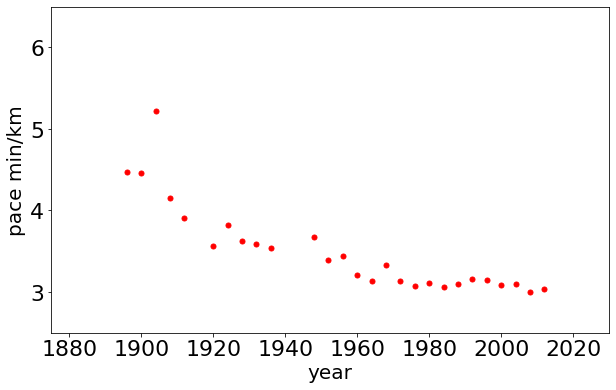

In [32]:
xlim = (1875,2030)
ylim = (2.5, 6.5)

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

mlai.write_figure(filename='olympic-marathon.svg', 
                  directory='./datasets')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/datasets/olympic-marathon.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Olympic marathon pace times since 1896.</i>

Things to notice about the data include the outlier in 1904, in this
year, the olympics was in St Louis, USA. Organizational problems and
challenges with dust kicked up by the cars following the race meant that
participants got lost, and only very few participants completed.

More recent years see more consistently quick marathons.

Polynomial Fits to Olympic Marthon Data
---------------------------------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/olympic-marathon-polynomial.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/olympic-marathon-polynomial.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

In [33]:
import numpy as np

Define the polynomial basis function.

In [ ]:
# %load -s polynomial mlai.py
def polynomial(x, num_basis=4, data_limits=[-1., 1.]):
    "Polynomial basis"
    centre = data_limits[0]/2. + data_limits[1]/2.
    span = data_limits[1] - data_limits[0]
    z = asarray(x, dtype=float) - centre
    z = 2*z/span
    Phi = zeros((x.shape[0], num_basis))
    for i in range(num_basis):
        Phi[:, i:i+1] = z**i
    return Phi


In [35]:
def polynomial(x, num_basis=4, data_limits=[-1., 1.]):
    "Polynomial basis"
    centre = data_limits[0]/2. + data_limits[1]/2.
    span = data_limits[1] - data_limits[0]
    z = np.asarray(x, dtype=float) - centre
    z = 2*z/span   # scale the inputs to be within -1, 1 where polynomials are well behaved
    Phi = np.zeros((x.shape[0], num_basis))
    for i in range(num_basis):
        Phi[:, i:i+1] = z**i
    return Phi

Now we include the solution for the linear regression through
QR-decomposition.

In [36]:
def basis_fit(Phi, y):
    "Use QR decomposition to fit the basis."""
    Q, R = np.linalg.qr(Phi)
    return sp.linalg.solve_triangular(R, Q.T@y) 

Linear Fit
----------

In [37]:
poly_args = {'num_basis':2, # two basis functions (1 and x)
             'data_limits':xlim}
Phi = polynomial(x, **poly_args)
w = basis_fit(Phi, y)

Now we make some predictions for the fit.

In [38]:
x_pred = np.linspace(xlim[0], xlim[1], 400)[:, np.newaxis]
Phi_pred = polynomial(x_pred, **poly_args)
f_pred = Phi_pred@w

In [39]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

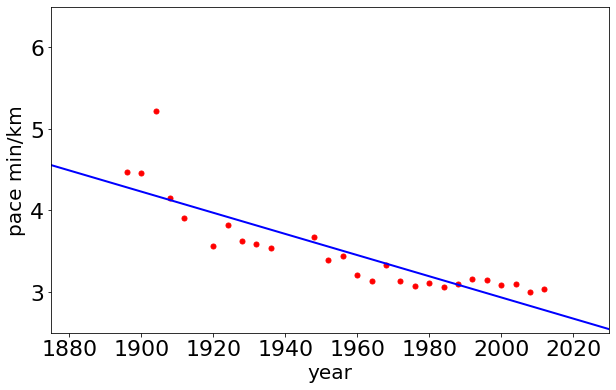

In [40]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

_ = ax.plot(x_pred, f_pred, 'b-', linewidth=2)

mlai.write_figure(filename='olympic-marathon-polynomial-2.svg', 
                  directory='./ml')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/olympic-marathon-polynomial-2.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Fit of a 1 degree polynomial (a linear model) to the olympic
marathon data.</i>

Cubic Fit
---------

In [41]:
poly_args = {'num_basis':4, # four basis: 1, x, x^2, x^3
             'data_limits':xlim}
Phi = polynomial(x, **poly_args)
w = basis_fit(Phi, y)

In [42]:
Phi_pred = polynomial(x_pred, **poly_args)
f_pred = Phi_pred@w

In [43]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

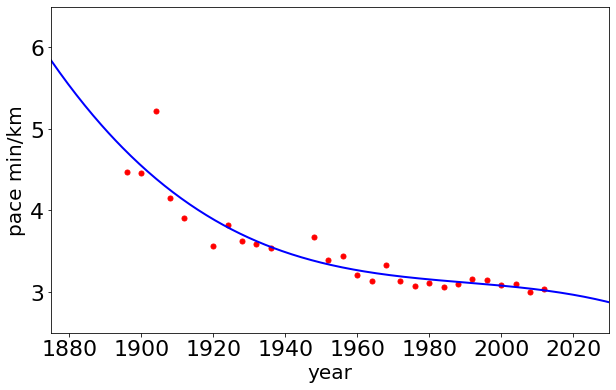

In [44]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

_ = ax.plot(x_pred, f_pred, 'b-', linewidth=2)

mlai.write_figure(filename='olympic-marathon-polynomial-4.svg', 
                  directory='./ml')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/olympic-marathon-polynomial-4.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Fit of a 3 degree polynomial (a cubic model) to the olympic
marathon data.</i>

9th Degree Polynomial Fit
-------------------------

Now we’ll try a 9th degree polynomial fit to the data.

In [45]:
poly_args = {'num_basis':10, # basis up to x^9
             'data_limits':xlim}
Phi = polynomial(x, **poly_args)
w = basis_fit(Phi, y)

In [46]:
Phi_pred = polynomial(x_pred, **poly_args)
f_pred = Phi_pred@w

In [47]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

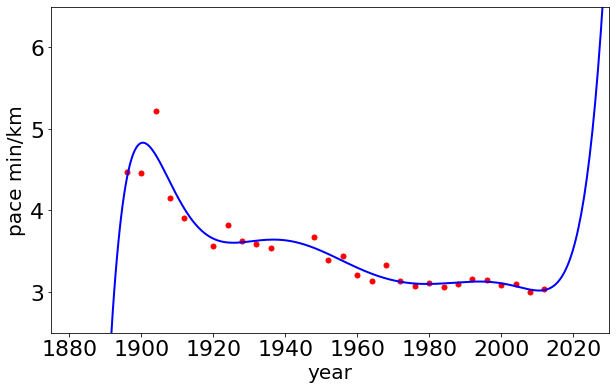

In [48]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

_ = ax.plot(x_pred, f_pred, 'b-', linewidth=2)

mlai.write_figure(filename='olympic-marathon-polynomial-10.svg', 
                  directory='./ml')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/olympic-marathon-polynomial-10.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Fit of a 9 degree polynomial to the olympic marathon
data.</i>

26th Degree Polynomial Fit
--------------------------

Now we’ll try a 26th degree polynomial fit to the data.

In [49]:
poly_args = {'num_basis':27, # basis up to x^26
             'data_limits':xlim}
Phi = polynomial(x, **poly_args)
w = basis_fit(Phi, y)

In [50]:
Phi_pred = polynomial(x_pred, **poly_args)
f_pred = Phi_pred@w

In [51]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

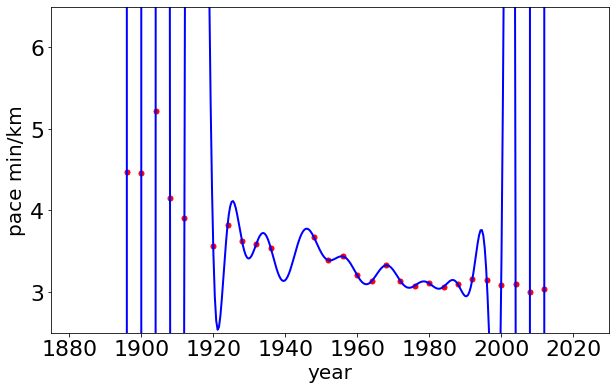

In [52]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

_ = ax.plot(x_pred, f_pred, 'b-', linewidth=2)

mlai.write_figure(filename='olympic-marathon-polynomial-27.svg', 
                  directory='./ml')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/olympic-marathon-polynomial-27.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Fit of a 26 degree polynomial to the olympic marathon
data.</i>

16th Degree Polynomial Fit
--------------------------

Now we’ll try a 16th degree polynomial fit to the data.

In [53]:
poly_args = {'num_basis':17, # basis up to x^16
             'data_limits':xlim}
Phi = polynomial(x, **poly_args)
w = basis_fit(Phi, y)

In [54]:
Phi_pred = polynomial(x_pred, **poly_args)
f_pred = Phi_pred@w

In [55]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

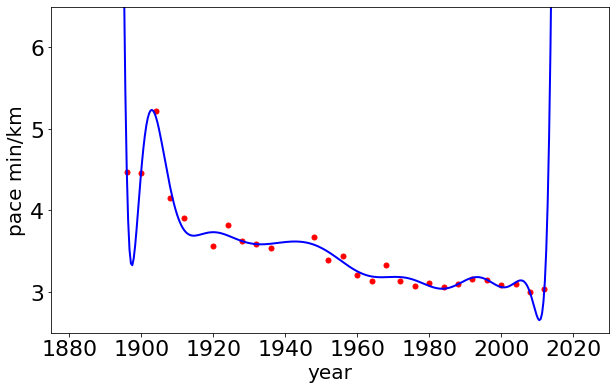

In [56]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

_ = ax.plot(x_pred, f_pred, 'b-', linewidth=2)

mlai.write_figure(filename='olympic-marathon-polynomial-17.svg', 
                  directory='./ml')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/olympic-marathon-polynomial-17.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Fit of a 16 degree polynomial to the olympic marathon
data.</i>

The Bootstrap
-------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/the-bootstrap.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/the-bootstrap.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

Bootstrap sampling (Efron, 1979) is an approach to assessing the
sensitivity of the model to different variations on a data set. In an
ideal world, we’d like to be able to look at different realisations from
the original data generating distribution $\mathbb{P}(y, \mathbf{ x})$,
but this is not available to us.

In bootstrap sampling, we take the sample we have, $$
\mathbf{ y}, \mathbf{X}\sim \mathbb{P}(y, \mathbf{ x})
$$ and resample from that data, rather than from the true distribution.
So we have a new data set, $\hat{\mathbf{ y}}$, $\hat{\mathbf{X}}$ which
is sampled from the original *with* replacement.

In [57]:
import numpy as np

In [58]:
def bootstrap(X):
    "Return a bootstrap sample from a data set."
    n = X.shape[0]
    ind = np.random.choice(n, n, replace=True) # Sample randomly with replacement.
    return X[ind, :]  

Bootstrap and Olympic Marathon Data
-----------------------------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/olympic-marathon-bootstrap-polynomial.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/olympic-marathon-bootstrap-polynomial.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

First we define a function to bootstrap resample our dataset.

In [59]:
import numpy as np

In [60]:
def bootstrap(X, y):
    "Return a bootstrap sample from a data set."
    n = X.shape[0]
    ind = np.random.choice(n, n, replace=True) # Sample randomly with replacement.
    return X[ind, :], y[ind, :]

In [61]:
num_bootstraps = 10

In [62]:
def bootstrap_fit(Phi, y, size):
    W = np.zeros((Phi.shape[1], size))
    for i in range(size):
        Phi_hat, y_hat = bootstrap(Phi, y)
        W[:, i:i+1] = basis_fit(Phi_hat, y_hat)
    return W

Linear Fit
----------

In [63]:
poly_args = {'num_basis':2, # two basis functions (1 and x)
             'data_limits':xlim}
Phi = polynomial(x, **poly_args)
W_hat = bootstrap_fit(Phi, y, num_bootstraps)

Now we make some predictions for the fit.

In [64]:
x_pred = np.linspace(xlim[0], xlim[1], 400)[:, np.newaxis]
Phi_pred = polynomial(x_pred, **poly_args)
f_pred = Phi_pred@W_hat

In [65]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

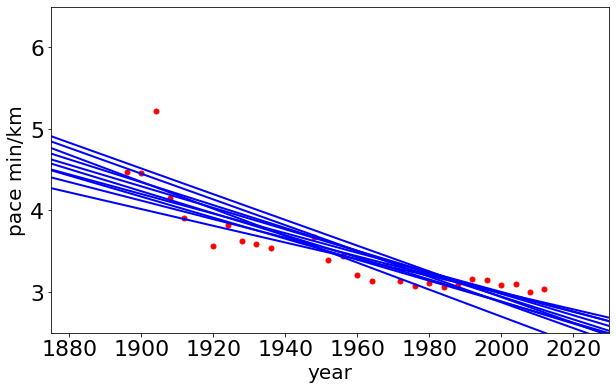

In [66]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

_ = ax.plot(x_pred, f_pred, 'b-', linewidth=2)

mlai.write_figure(filename='olympic-marathon-bootstrap-polynomial-2.svg', 
                  directory='./ml')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/olympic-marathon-bootstrap-polynomial-2.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Fit of a 1 degree polynomial (a linear model) to the olympic
marathon data.</i>

Cubic Fit
---------

In [67]:
poly_args = {'num_basis':4, # four basis: 1, x, x^2, x^3
             'data_limits':xlim}
Phi = polynomial(x, **poly_args)
W_hat = bootstrap_fit(Phi, y, num_bootstraps)

In [68]:
Phi_pred = polynomial(x_pred, **poly_args)
f_pred = Phi_pred@W_hat

In [69]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

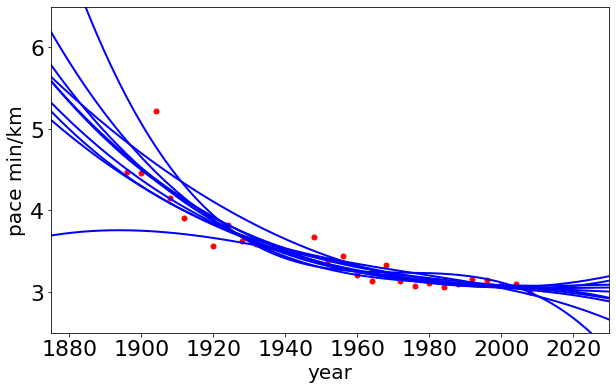

In [70]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

_ = ax.plot(x_pred, f_pred, 'b-', linewidth=2)

mlai.write_figure(filename='olympic-marathon-bootstrap-polynomial-4.svg', 
                  directory='./ml')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/olympic-marathon-bootstrap-polynomial-4.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Fit of a 3 degree polynomial (a cubic model) to the olympic
marathon data.</i>

9th Degree Polynomial Fit
-------------------------

Now we’ll try a 9th degree polynomial fit to the data.

In [71]:
poly_args = {'num_basis':10, # basis up to x^9
             'data_limits':xlim}
Phi = polynomial(x, **poly_args)
W_hat = bootstrap_fit(Phi, y, num_bootstraps)

In [72]:
Phi_pred = polynomial(x_pred, **poly_args)
f_pred = Phi_pred@W_hat

In [73]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

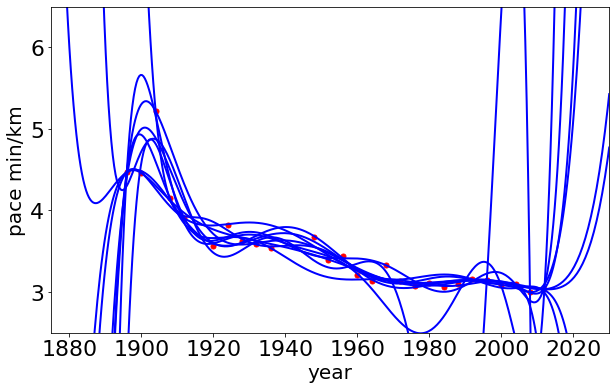

In [74]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

_ = ax.plot(x_pred, f_pred, 'b-', linewidth=2)

mlai.write_figure(filename='olympic-marathon-bootstrap-polynomial-10.svg', 
                  directory='./ml')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/olympic-marathon-bootstrap-polynomial-10.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Fit of a 9 degree polynomial to the olympic marathon
data.</i>

16th Degree Polynomial Fit
--------------------------

Now we’ll try a 16th degree polynomial fit to the data.

In [75]:
poly_args = {'num_basis':17, # basis up to x^16
             'data_limits':xlim}
Phi = polynomial(x, **poly_args)
W_hat = bootstrap_fit(Phi, y, num_bootstraps)

In [76]:
Phi_pred = polynomial(x_pred, **poly_args)
f_pred = Phi_pred@W_hat

In [77]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

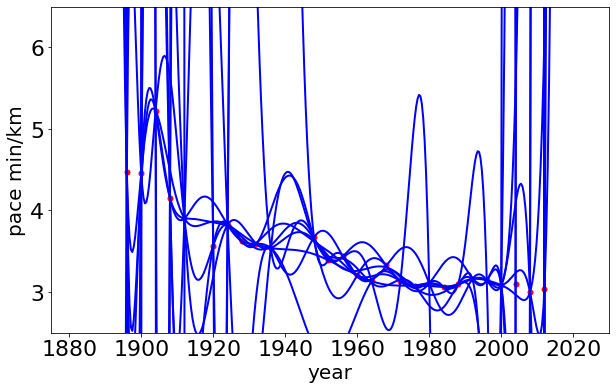

In [78]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

_ = ax.plot(x_pred, f_pred, 'b-', linewidth=2)

mlai.write_figure(filename='olympic-marathon-bootstrap-polynomial-17.svg', 
                  directory='./ml')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/olympic-marathon-bootstrap-polynomial-17.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Fit of a 16 degree polynomial to the olympic marathon
data.</i>

Bias Variance Decomposition
---------------------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/bias-variance-dilemma.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/bias-variance-dilemma.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

One of Breiman’s ideas for improving predictive performance is known as
bagging (Breiman, 1996). The idea is to train a number of models on the
data such that they overfit (high variance). Then average the
predictions of these models. The models are trained on different
bootstrap samples (Efron, 1979) and their predictions are aggregated
giving us the acronym, Bagging. By combining decision trees with
bagging, we recover random forests (Breiman, 2001).

Bias and variance can also be estimated through Efron’s bootstrap
(Efron, 1979), and the traditional view has been that there’s a form of
Goldilocks effect, where the best predictions are given by the model
that is ‘just right’ for the amount of data available. Not to simple,
not too complex. The idea is that bias decreases with increasing model
complexity and variance increases with increasing model complexity.
Typically plots begin with the Mummy bear on the left (too much bias)
end with the Daddy bear on the right (too much variance) and show a dip
in the middle where the Baby bear (just) right finds themselves.

The Daddy bear is typically positioned at the point where the model is
able to exactly interpolate the data. For a generalized linear model
(McCullagh and Nelder, 1989), this is the point at which the number of
parameters is equal to the number of data[1].

The bias-variance decomposition (Geman et al., 1992) considers the
expected test error for different variations of the *training data*
sampled from, $\mathbb{P}(\mathbf{ x}, y)$ $$
\mathbb{E}\left[ \left(y- f^*(\mathbf{ x})\right)^2 \right].
$$ This can be decomposed into two parts, $$
\begin{align*}
\mathbb{E}\left[ \left(y- f(\mathbf{ x})\right)^2 \right] = & \text{bias}\left[f^*(\mathbf{ x})\right]^2 \\
& + \text{variance}\left[f^*(\mathbf{ x})\right] +\sigma^2,
\end{align*}
$$ where the bias is given by $$
  \text{bias}\left[f^*(\mathbf{ x})\right] =
\mathbb{E}\left[f^*(\mathbf{ x})\right] * f(\mathbf{ x})
$$ and it summarizes error that arises from the model’s inability to
represent the underlying complexity of the data. For example, if we were
to model the marathon pace of the winning runner from the Olympics by
computing the average pace across time, then that model would exhibit
*bias* error because the reality of Olympic marathon pace is it is
changing (typically getting faster).

The variance term is given by $$
  \text{variance}\left[f^*(\mathbf{ x})\right] = \mathbb{E}\left[\left(f^*(\mathbf{ x}) - \mathbb{E}\left[f^*(\mathbf{ x})\right]\right)^2\right].
  $$ The variance term is often described as arising from a model that
is too complex, but we have to be careful with this idea. Is the model
really too complex relative to the real world that generates the data?
The real world is a complex place, and it is rare that we are
constructing mathematical models that are more complex than the world
around us. Rather, the ‘too complex’ refers to ability to estimate the
parameters of the model given the data we have. Slight variations in the
training set cause changes in prediction.

Models that exhibit high variance are sometimes said to ‘overfit’ the
data whereas models that exhibit high bias are sometimes described as
‘underfitting’ the data.

Also related on generalisation error is the so called ‘no free lunch
theorem’, which refers to our inability to decide what a better learning
algorithm is without making assumptions about the data (Wolpert, 1996)
(see also Wolpert (2002)).

[1] Assuming we are ignoring parameters in the link function and the
distribution function.

Regularisation
--------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/linear-regression-regularisation.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/linear-regression-regularisation.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

The solution to the linear system is given by solving, $$
\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ w}= \boldsymbol{ \Phi}^\top\mathbf{ y}
$$ for $\mathbf{ w}$.

But if $\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}$ is not full rank,
this system cannot be solved. This is reflective of an *underdetermined
system* of equations. There are *infinite* solutions. This happens when
there are more basis functions than data points, in effect the number of
data we have is not enough to determine the parameters.

Thinking about this in terms of the Hessian, if
$\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}$ is not full rank, then we
are no longer at a minima. We are in some kind of trough, because *not
full rank* implies that there are fewer eigenvectors than dimensions, in
effect for those dimensions where there is no eigenvector, the objective
function is ‘flat’. It is ambivalent to changes in parameters. This
implies there are infinite valid solutions.

One solution to this problem is to regularise the problem.

Coefficient Shrinkage
---------------------

Coefficient shrinkage is a technique where the parameters of the of the
model are ‘encouraged’ to be small. In practice this is normally done by
augmenting the objective function with a term that keeps the paremeters
low, typically by penaalising a norm.

Tikhonov Regularisation
-----------------------

In neural network models this approach is sometimes called ‘weight
decay’. At every gradient step we reduce the value of the weight a
little. This idea comes from an approach callled Tikhonov regularisation
(Tikhonov and Arsenin, 1977), where the objective function is augmented
by the L2 norm of the weights, $$
L(\mathbf{ w}) = (\mathbf{ y}- \mathbf{ f})^\top(\mathbf{ y}- \mathbf{ f}) + \alpha\left\Vert \mathbf{W} \right\Vert_2^2
$$ with some weighting $\alpha >0$. This has the effect of changing the
Hessian at the minimua to $$
\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}+ \alpha \mathbf{I}
$$ Which is always full rank. The minimal eigenvalues are now given by
$\alpha$.

Lasso
-----

Other techniques for regularisation based on a norm of the parameters
include the Lasso Tibshirani (1996), which is an L1 norm of the
parameters

Splines, Functions, Hilbert Kernels
-----------------------------------

Regularisation of the parameters has the desired effect of making the
solution viable, but it can sometimes be difficult to interpret,
particularly if the parameters don’t have any inherent meaning (like in
a neural network). An alternative approach is to regularise the
function, $\mathbf{ f}$, directly, (see e.g. Kimeldorf and Wahba (1970)
and Wahba (1990)). This is the approach taken by *spline models* which
use energy based regularisation for $f(\cdot)$ and also *kernel methods*
such as the support vector machine (Schölkopf and Smola, 2001).

Training with Noise
-------------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/training-with-noise-tikhonov-regularisation.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ml/includes/training-with-noise-tikhonov-regularisation.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

In practice, and across the last two waves of neural networks, other
techniques for regularisation have been used which can be seen as
perturbing the neural network in some way. For example, in dropout
(Srivastava et al., 2014), different basis functions are eliminated from
the gradient computation at each gradient update.

Many of these pertubations have some form of regularising effect. The
exact nature of the effect is not always easy to characterise, but in
some cases we can assess how these manipulations effect the model. For
example, Bishop (1995) analyzed training with ‘noisy inputs’ and showed
conditions under which it’s equivalent to Tikhonov regularisation.

But in general these approaches can have different interpretations and
they’ve also been related to ensemble learning (e.g. related to
*bagging* or Bayesian approaches).

<!--include{_ml/includes/bayesian-interpretation-of-regularisation.md}-->

Overparameterised Systems
-------------------------

If we could examine the Hessian of a neural network at its minimum, we
can speculate about what we would find. In particular, we would find
that it would have very many low (or negative) eigenvalues in many
directions. This is indicative of the parameters being *badly
determined* as a result of the neural network model being heavily
*overparameterised*. So how does it generalise?

Simply put, there is not enough regularisation encoded in the objective
function of the neural network models we are using to explain the
generalisation performance. There must be something in the algorithms we
are using that causes these highly overparameterised models to
generalise well.

Double Descent
--------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_deepnn/includes/double-descent.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_deepnn/includes/double-descent.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/double-descent.png" style="width:100%">

Figure: <i>*Left* traditional perspective on generalisation. There is a
sweet spot of operation where the training error is still non-zero.
Overfitting occurs when the variance increases. *Right* The double
descent phenomenon, the modern models operate in an interpolation regime
where they reconstruct the training data fully, but are well regularised
in their interpolations for test data. Figure from Belkin et al.
(2019).</i>

But the modern empirical finding is that when we move beyond Daddy bear,
into the dark forest of the massively overparameterized model we can
achieve good generalization. Indeed, recent work is showing that large
language models are even *memorising* data (Carlini et al., 2020) like
non-parametric models do.

As Zhang et al. (2017) starkly illustrated with their random labels
experiment, within the dark forest there are some terrible places, big
bad wolves of overfitting that will gobble up your model. But as
empirical evidence shows there is also a safe and hospitable Grandma’s
house where these highly overparameterized models are safely consumed.
Fundamentally, it must be about the route you take through the forest,
and the precautions you take to ensure the wolf doesn’t see where you’re
going and beat you to the door.

There are two implications of this empirical result. Firstly, that there
is a great deal of new theory that needs to be developed. Secondly, that
theory is now obliged to conflate two aspects to modelling that we
generally like to keep separate: the model and the algorithm.

Classical statistical theory around predictive generalization focusses
specifically on the class of models that is being used for data fitting.
Historically, whether that theory follows a Fisher-aligned estimation
approach (see e.g. Vapnik (1998)) or model-based Bayesian approach (see
e.g. Ghahramani (2015)), neither is fully equipped to deal with these
new circumstances because, to continue our rather tortured analogy,
these theories provide us with a characterization of the *destination*
of the algorithm, and seek to ensure that we reach that destination.
Modern machine learning requires theories of the *journey* and what our
route through the forest should be.

Crucially, the destination is always associated with 100% accuracy on
the training set. An objective that is always achievable for the
overparameterized model.

Intuitively, it seems that a highly overparameterized model places
Grandma’s house on the edge of the dark forest. Making it easily and
quickly accessible to the algorithm. The larger the model, the more
exposed Grandma’s house becomes. Perhaps this is due to some form of
blessing of dimensionality brings Grandma’s house closer to the edge of
the forest in a high dimensional setting. Really, we should think of
Grandma’s house as a low dimensional manifold of destinations that are
safe. A path through the forest where the wolf of overfitting doesn’t
venture. In the GLM case, we know already that when the number of
parameters matches the number of data there is precisely one location in
parameter space where accuracy on the training data is 100%. Our
previous misunderstanding of generalization stemmed from the fact that
(seemingly) it is highly unlikely that this single point is a good place
to be from the perspective of generalization. Additionally, it is often
difficult to find. Finding the precise polynomial coefficients in a
least squares regression to exactly fit the basis to a small data set
such as the Olympic marathon data requires careful consideration of the
numerical properties and an orthogonalization of the design matrix
(Lawson and Hanson, 1995).

It seems that with a highly overparameterized model, these locations
become easier to find and they provide good generalization properties.
In machine learning this is known as the “double descent phenomenon”
(see e.g. Belkin et al. (2019)).

See also this talk by Misha Belkin:
<a href="http://www.ipam.ucla.edu/abstract/?tid=15552&amp;pcode=GLWS4" class="uri">http://www.ipam.ucla.edu/abstract/?tid=15552&amp;pcode=GLWS4</a>
and these related papers
<a href="https://www.pnas.org/content/116/32/15849.short" class="uri">https://www.pnas.org/content/116/32/15849.short</a>,
<a href="https://www.pnas.org/content/117/20/10625" class="uri">https://www.pnas.org/content/117/20/10625</a>

Neural Tangent Kernel
---------------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_deepnn/includes/neural-tangent-kernel.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_deepnn/includes/neural-tangent-kernel.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

Another approach to analysis exploits the fact that optimization is
occuring in a very high dimensional parameter space. By considering
initialisations that involve small random weights (known as the NTK
initialisation) and noting that small updates in the learning mean that
the model doesn’t move far from this initialisation (Jacot et al.,
2018).

For very wide neural networks, when these conditions are fulfilled, the
network can be approximately represented by a *kernel* known as the
neural tangent kernel. A kernel is a regulariser that operates in
*function space* rather than *feature space*.

Regularisation in Optimisation
------------------------------

<span style="text-align:right"><span class="editsection-bracket"
style="">\[</span><span class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_deepnn/includes/regularisation-in-optimisation.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_deepnn/includes/regularisation-in-optimisation.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span></span>

Another interesting theoretical direction is to study the path that
neural network algorithms take when finding the optima. For certain
simple linear systems, you can analytically study the ‘gradient flow’.

Neural networks are normally trained by (stochastic) gradient descent.
This is a discrete optimisation algorithm where at each point, a step in
the direction of the (approximate) gradient is taken.

Gradient flow replaces this discrete update with a differential
equation, where the step at any point is considered to be an exact
gradient update. As a result the path of the optimsation can be studied
as a *differential equation*.

By making assumptions about the initialisation, the optima that gradient
flow will find can be characterised. For a highly overparameterised
linear model, Gunasekar et al. (2017) show in matrix factorization, that
for particular initialisations, the optima will be a *global* optima of
the objective that minimises the L2-norm.

By reparameterising the linear model so that each $w_i = u_i^2 - v_i^2$
and optimising in the space defined by $\mathbf{u}$ and $\mathbf{v}$
Woodworth et al. (2020) show that the L1 norm is found.

Other papers have looked at *deep linear models* (Arora et al., 2019),
where $$
f(\mathbf{ x}; \mathbf{W}) = \mathbf{W}_4 \mathbf{W}_3 \mathbf{W}_2 \mathbf{W}_1 \mathbf{ x}.
$$ {In these models, a gradient flow analysis shows that the model finds
solutions where the linear mapping, $$
\mathbf{W}= \mathbf{W}_4 \mathbf{W}_3 \mathbf{W}_2 \mathbf{W}_1 
$$ is very low rank. This is highly suggestive of another type of
regularisation that could be occurring in deep neural networks. Low rank
parameter matrices mean that the effective capacity of the neural
network is reduced. Indeed empirical observations of the rank of deep
nets trained on data suggest that they may be finding such solutions.

Thanks!
-------

For more information on these subjects and more you might want to check
the following resources.

-   twitter: [@lawrennd](https://twitter.com/lawrennd)
-   podcast: [The Talking Machines](http://thetalkingmachines.com)
-   newspaper: [Guardian Profile
    Page](http://www.theguardian.com/profile/neil-lawrence)
-   blog:
    [http://inverseprobability.com](http://inverseprobability.com/blog.html)

References
----------

bootstrap

David Hogg’s lecture
<a href="https://speakerdeck.com/dwhgg/linear-regression-with-huge-numbers-of-parameters" class="uri">https://speakerdeck.com/dwhgg/linear-regression-with-huge-numbers-of-parameters</a>

The Deep Bootstrap
<a href="https://twitter.com/PreetumNakkiran/status/1318007088321335297?s=20" class="uri">https://twitter.com/PreetumNakkiran/status/1318007088321335297?s=20</a>

Aki Vehtari on Leave One Out Uncertainty:
<a href="https://arxiv.org/abs/2008.10296" class="uri">https://arxiv.org/abs/2008.10296</a>
(check for his references).

Arora, S., Cohen, N., Golowich, N., Hu, W., 2019. A convergence analysis
of gradient descent for deep linear neural networks, in: International
Conference on Learning Representations.

Belkin, M., Hsu, D., Ma, S., Soumik Mandal, 2019. Reconciling modern
machine-learning practice and the classical bias-variance trade-off.
Proc. Natl. Acad. Sci. USA 116, 15849–15854.

Bishop, C.M., 1995. Training with noise is equivalent to Tikhonov
regularization. Neural Computation 7, 108–116.
<https://doi.org/10.1162/neco.1995.7.1.108>

Bishop, C.M., 1992. Exact calculation of the hessian matrix for the
multilayer perceptron. Neural Computation 4, 494–501.
<https://doi.org/10.1162/neco.1992.4.4.494>

Breiman, L., 2001. Random forests. Mach. Learn. 45, 5–32.
<https://doi.org/10.1023/A:1010933404324>

Breiman, L., 1996. Bagging predictors. Machine Learning 24, 123–140.
<https://doi.org/10.1007/BF00058655>

Carlini, N., Tramèr, F., Wallace, E., Jagielski, M., Herbert-Voss, A.,
Lee, K., Roberts, A., Brown, T., Song, D., Erlingsson, U., Oprea, A.,
Raffel, C., 2020. Extracting training data from large language models.

Efron, B., 1979. Bootstrap methods: Another look at the jackkife. Annals
of Statistics 7, 1–26.

Geman, S., Bienenstock, E., Doursat, R., 1992. Neural networks and the
bias/variance dilemma. Neural Computation 4, 1–58.
<https://doi.org/10.1162/neco.1992.4.1.1>

Ghahramani, Z., 2015. Probabilistic machine learning and artificial
intelligence. Nature 452–459.

Gunasekar, S., Woodworth, B., Bhojanapalli, S., Neyshabur, B., Srebro,
N., 2017. Implicit regularization in matrix factorization.

Jacot, A., Gabriel, F., Hongler, C., 2018. Neural tangent kernel:
Convergence and generalization in neural networks, in: Bengio, S.,
Wallach, H., Larochelle, H., Grauman, K., Cesa-Bianchi, N., Garnett, R.
(Eds.), Advances in Neural Information Processing Systems. Curran
Associates, Inc., pp. 8571–8580.

Kimeldorf, G.S., Wahba, G., 1970. A correspondence between Bayesian
estimation of stochastic processes and smoothing by splines. Annals of
Mathematical Statistics 41, 495–502.

Lawson, C.L., Hanson, R.J., 1995. Solving least squares problems. SIAM.
<https://doi.org/10.1137/1.9781611971217>

McCullagh, P., Nelder, J.A., 1989. Generalized linear models, 2nd ed.
Chapman; Hall.

Schölkopf, B., Smola, A.J., 2001. Learning with kernels. mit, Cambridge,
MA.

Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I.,
Salakhutdinov, R., 2014. Dropout: A simple way to prevent neural
networks from overfitting. Journal of Machine Learning Research 15,
1929–1958.

The Office of the Senior Special Assistant to the President on the
Millennium Development Goals (OSSAP-MDGs), Columbia University, 2014.
Nigeria NMIS facility database.

Tibshirani, R., 1996. Regression shrinkage and selection via the lasso.
Journal of the Royal Statistical Society. Series B (Methodological) 58,
267–288.

Tikhonov, A.N., Arsenin, V.Y., 1977. Solutions of ill-posed problems. V.
H. Winston, Washington, DC.

Vapnik, V.N., 1998. Statistical learning theory. wiley, New York.

Wahba, G., 1990. Spline models for observational data, First. ed. SIAM.
<https://doi.org/10.1137/1.9781611970128>

Wolpert, D.H., 2002. The supervised learning no-free-lunch theorems, in:
Roy, R., Köppen, M., Ovaska, S., Furuhashi, T., Hoffmann, F. (Eds.),
Soft Computing and Industry. Springer, London, pp. 25.
<https://doi.org/10.1007/978-1-4471-0123-9_3>

Wolpert, D.H., 1996. The lack of a priori distinctions between learning
algorithms. Neural Computation 8.
<https://doi.org/10.1162/neco.1996.8.7.1341>

Woodworth, B., Gunasekar, S., Lee, J.D., Moroshko, E., Savarese, P.,
Golan, I., Soudry, D., Srebro, N., 2020. Kernel and rich regimes in
overparametrized models.

Zhang, C., Bengio, S., Hardt, M., Recht, B., Vinyals, O., 2017.
Understanding deep learning requires rethinking generalization, in:
https://openreview.net/forum?id=Sy8gdB9xx (Ed.), International
Conference on Learning Representations.